**Chapter 3: Sampling the Imaginary**

The purpose of this notebook is to learn the Bayesian code from the [Statistical Rethinking book](https://xcelab.net/rm/statistical-rethinking/) using Python. I will use the R `rethinking` package as a point of comparison. Python code is primarily from [here](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_03.ipynb) or  may be taken [here](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_03.ipynb).



In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

In [4]:
# Run R code for comparison of code
%load_ext rpy2.ipython

<IPython.core.display.Javascript object>

In [5]:
%%R                                       # All R cells will be indicated with %%R at the top of the cell
suppressMessages(library(tidyverse))
suppressMessages(library(rethinking))

<IPython.core.display.Javascript object>

# Code 3.1

Bayes theorem:

Pr(vampire|positive) = [Pr(positive|vampire)Pr(vampire)] / Pr(positive)

## R

In [14]:
%%R

Pr_Positive_Vampire <- 0.95
Pr_Positive_Mortal <- 0.01
Pr_Vampire <- 0.001
Pr_Positive <- Pr_Positive_Vampire * Pr_Vampire + Pr_Positive_Mortal * ( 1 - Pr_Vampire )

( Pr_Vampire_Positive <- Pr_Positive_Vampire*Pr_Vampire / Pr_Positive )

print(Pr_Vampire_Positive)

[1] 0.08683729


<IPython.core.display.Javascript object>

## Python

In [15]:
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

<IPython.core.display.Javascript object>

# Code 3.2 and 3.3

Review: Compute the posterior for the globe tossing model, using grid approximation.


## R

In [59]:
%%R

p_grid <- seq( from=0 , to=1 , length.out=1000 )
prob_p <- rep( 1 , 1000 )
prob_data <- dbinom( 6 , size=9 , prob=p_grid )
posterior <- prob_data * prob_p
posterior <- posterior / sum(posterior)

<IPython.core.display.Javascript object>

"Now we wish to draw 10,000 samples from this posterior. Imagine the posterior is a bucket full of parameter values, numbers such as 0.1, 0.7, 0.5, 1, etc. **Within the bucket, each value exists in proportion to its posterior probability, such that values near the peak are much more common than those in the tails. We’re going to scoop out 10,000 values from the bucket.** Provided the bucket is well mixed, the resulting samples will have the same proportions as the exact posterior density. Therefore the individual values of p will appear in our samples in proportion to the posterior plausibility of each value."

In [60]:
%%R

samples <- sample( p_grid , prob=posterior , size=1e4 , replace=TRUE )

<IPython.core.display.Javascript object>

## Python


In [42]:
def posterior_grid_approx(grid_points, success, tosses):
    """"""
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    # prior = (p_grid >= 0.5).astype(int)  # truncated
    # prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

<IPython.core.display.Javascript object>

Sample from the posterior distribution. Explanation of `np.random.choice` function [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html).

In [43]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

<IPython.core.display.Javascript object>

### Evaluation of values with fewer grid points

In [49]:
p_grid, posterior = posterior_grid_approx(grid_points=20, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

<IPython.core.display.Javascript object>

In [50]:
p_grid

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

<IPython.core.display.Javascript object>

In [51]:
posterior

array([0.00000000e+00, 7.98983711e-07, 4.30771684e-05, 4.09079660e-04,
       1.89388732e-03, 5.87387288e-03, 1.40429377e-02, 2.78517436e-02,
       4.78011547e-02, 7.28073907e-02, 9.98729639e-02, 1.24264330e-01,
       1.40314323e-01, 1.42834880e-01, 1.28943257e-01, 9.98729639e-02,
       6.20588995e-02, 2.64547661e-02, 4.65967300e-03, 0.00000000e+00])

<IPython.core.display.Javascript object>

In [54]:
np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

array([0.68421053, 0.52631579, 0.57894737, ..., 0.47368421, 0.73684211,
       0.57894737])

<IPython.core.display.Javascript object>

# Code 3.4

Plot the distribution.

## R

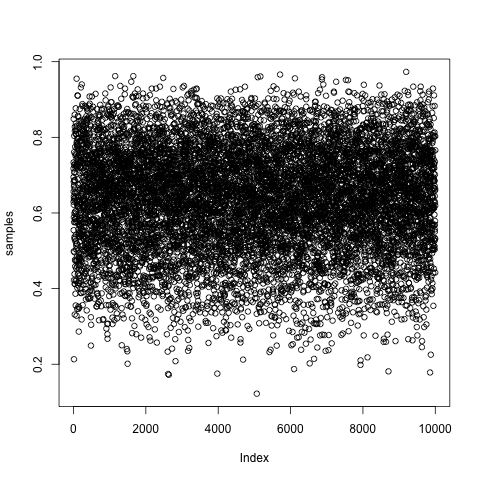

<IPython.core.display.Javascript object>

In [55]:
%%R

plot(samples)

## Python

In [57]:
# Re-run with book's values
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

<IPython.core.display.Javascript object>

Text(0, 0.5, 'proportion water (p)')

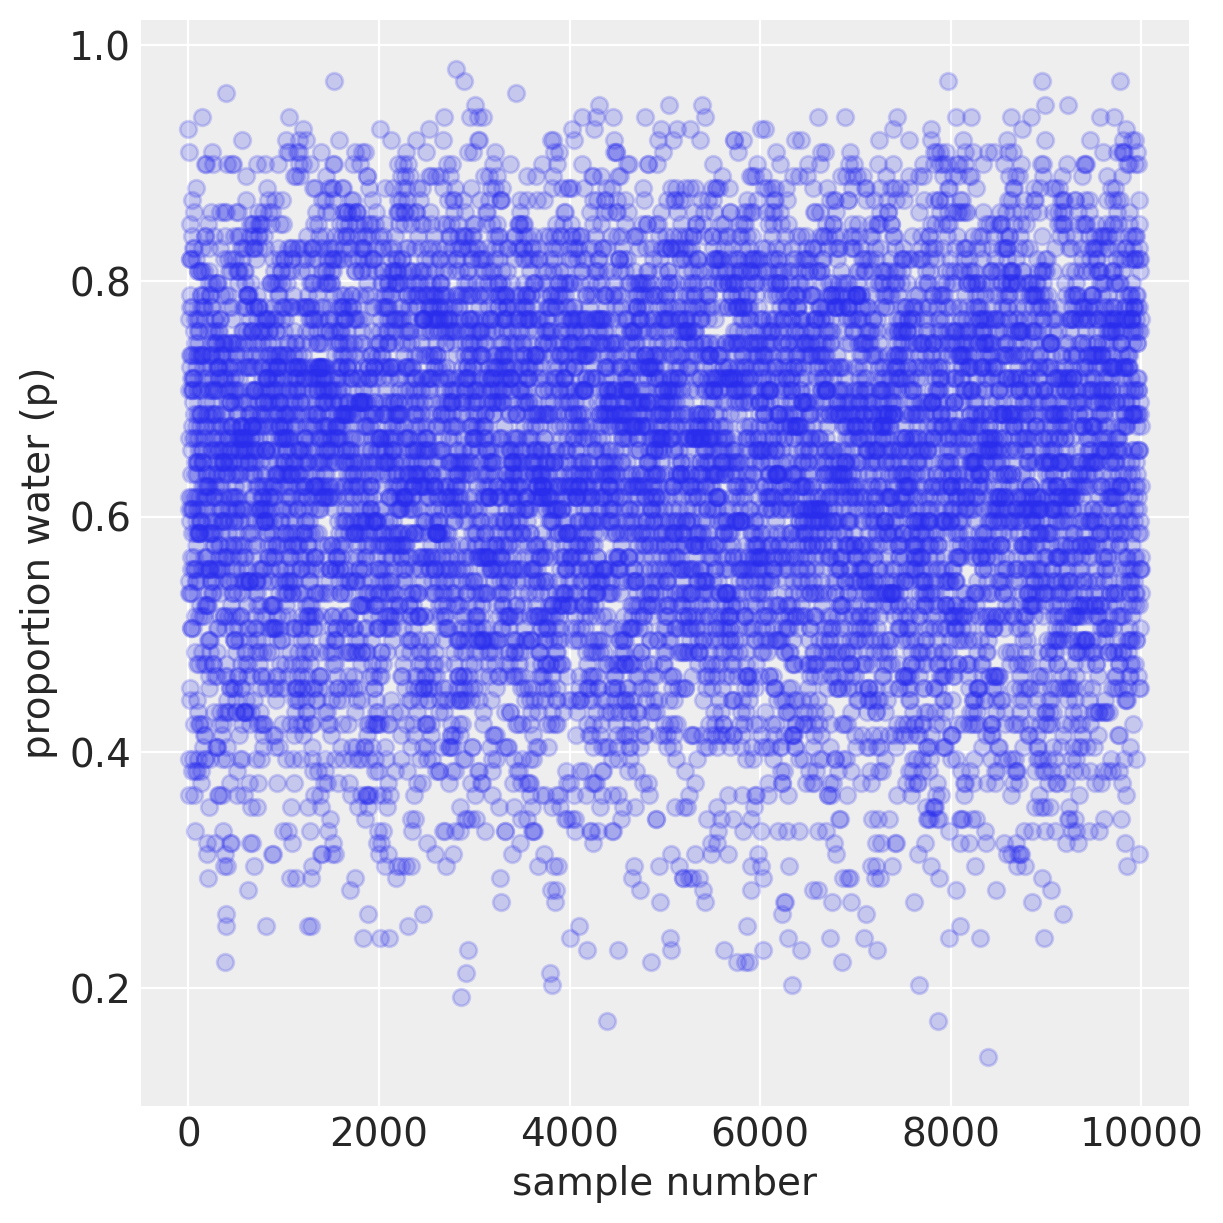

<IPython.core.display.Javascript object>

In [62]:
# _, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
_, (ax0) = plt.subplots(1, 1, figsize=(6, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number", fontsize=14)
ax0.set_ylabel("proportion water (p)", fontsize=14)
# sns.kdeplot(samples, ax=ax1)
# ax1.set_xlabel("proportion water (p)", fontsize=14)
# ax1.set_ylabel("density", fontsize=14)

# Code 3.5

Looking at density of values in posterior distribution.

## R

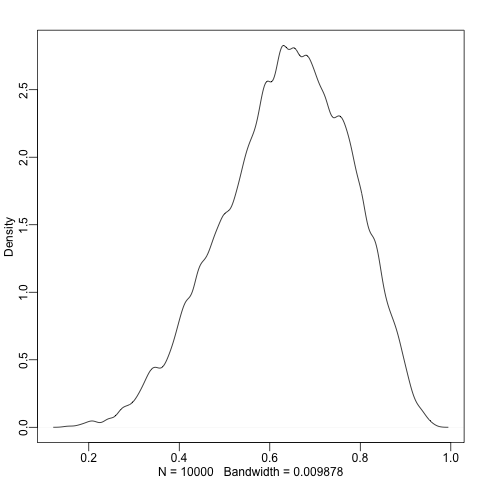

<IPython.core.display.Javascript object>

In [61]:
%%R

dens( samples )

## Python

Confirmed that R's density plot is a KDE [here](https://www.statmethods.net/graphs/density.html).

Text(0, 0.5, 'density')

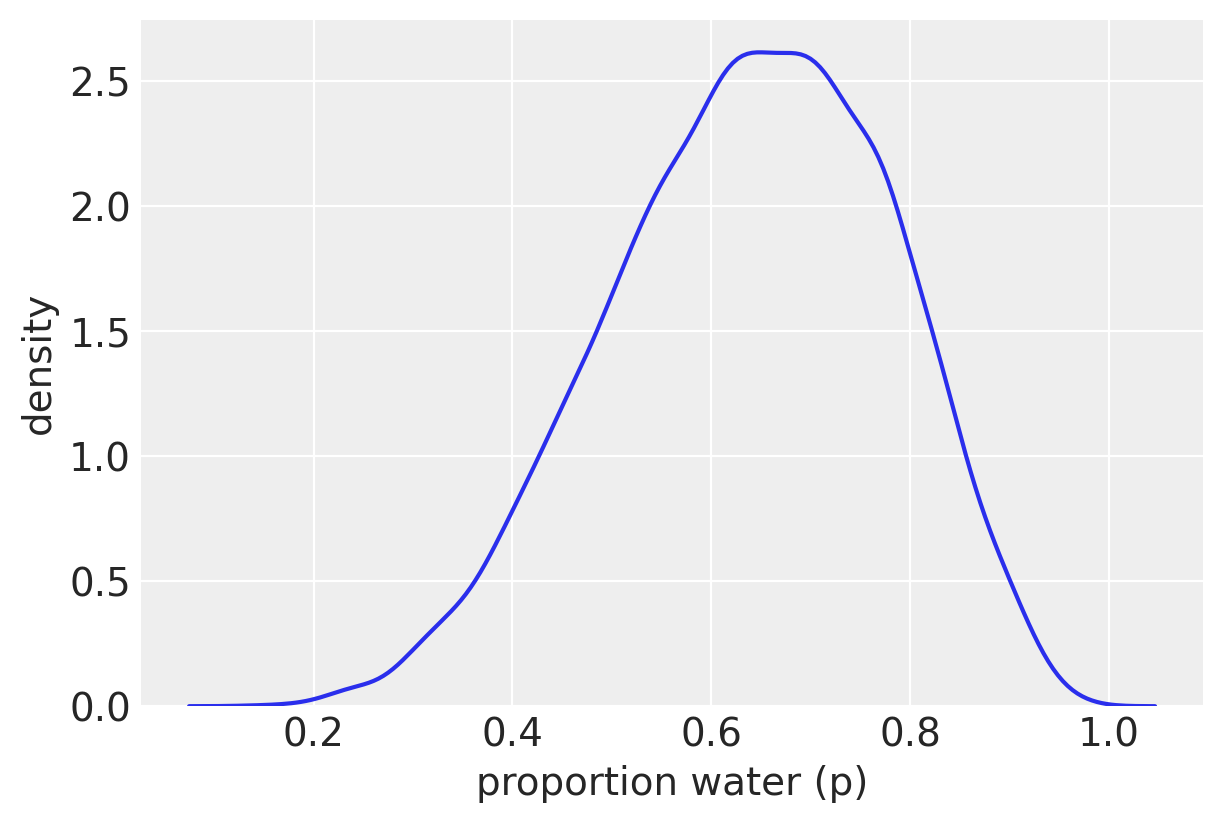

<IPython.core.display.Javascript object>

In [65]:
# _, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
_, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
# ax0.plot(samples, "o", alpha=0.2)
# ax0.set_xlabel("sample number", fontsize=14)
# ax0.set_ylabel("proportion water (p)", fontsize=14)
sns.kdeplot(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)", fontsize=14)
ax1.set_ylabel("density", fontsize=14)

# Code 3.6

Suppose I ask you for the posterior probability that the proportion of water is less than 0.5. Using the grid-approximate posterior, you can just add up all of the probabilities, where the corresponding parameter value is less than 0.5

## R

In [72]:
%%R

# add up posterior probability where p < 0.5
sum( posterior[ p_grid < 0.5 ] )

[1] 0.1718746


<IPython.core.display.Javascript object>

## Python

In [73]:
sum(posterior[p_grid < 0.5])

0.17183313110747478

<IPython.core.display.Javascript object>

# Code 3.7

So let’s see how to perform the same calculation, using samples from the posterior. **This approach does generalize to complex models with many parameters, and so you can use it everywhere.** All you have to do is similarly add up all of the samples below 0.5, but also divide the resulting count by the total number of samples. In other words, find the frequency of parameter values below 0.5

## R

In [74]:
%%R

sum( samples < 0.5 ) / 1e4

[1] 0.1752


<IPython.core.display.Javascript object>

## Python

In [75]:
sum(samples < 0.5) / 1e4

0.1745

<IPython.core.display.Javascript object>

# Code 3.8

Using the same approach, you can ask how much posterior probability lies between 0.5 and 0.75. See picture from book [here (login to O'Reilly required)](https://learning.oreilly.com/library/view/statistical-rethinking-2nd/9780429639142/xhtml/11_Chapter03.xhtml).

## R

In [76]:
%%R

sum( samples > 0.5 & samples < 0.75 ) / 1e4

[1] 0.5992


<IPython.core.display.Javascript object>

## Python

In [77]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.5983

<IPython.core.display.Javascript object>

# Code 3.9

Getting "credible" AKA "compatibility" interval.

## R

In [80]:
%%R

# Getting boundaries of the lower 80% posterior probability

quantile( samples , 0.8 )

      80% 
0.7617618 


<IPython.core.display.Javascript object>

## Python

In [81]:
np.percentile(samples, 80)

0.7676767676767677

<IPython.core.display.Javascript object>

# Code 3.10

Getting the middle 80% interval lies between the 10th percentile and the 90th percentile. These boundaries are found using the same approach.

## R

In [84]:
%%R

quantile(samples, c( 0.1 , 0.9 ) )   # Note: book had an error where there was no comma "after samples"

      10%       90% 
0.4464464 0.8118118 


<IPython.core.display.Javascript object>

## Python

In [85]:
np.percentile(samples, [10, 90])

array([0.44444444, 0.81818182])

<IPython.core.display.Javascript object>

# Code 3.11

Looking at density of values in posterior distribution.

## R

In [86]:
%%R

p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior <- rep(1,1000)
likelihood <- dbinom( 3 , size=3 , prob=p_grid )
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
samples <- sample( p_grid , size=1e4 , replace=TRUE , prob=posterior )

<IPython.core.display.Javascript object>

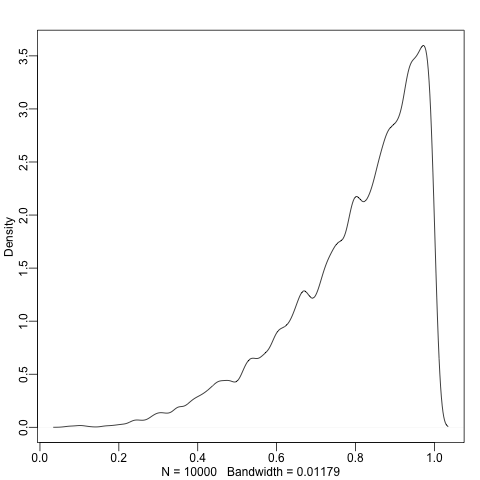

<IPython.core.display.Javascript object>

In [102]:
%%R
# Added figure for my own visualization here but figure is 3.3 in book
# but it's not a KDE, line shouldn't go down)
dens(samples)

## Python

Text(0, 0.5, 'Density')

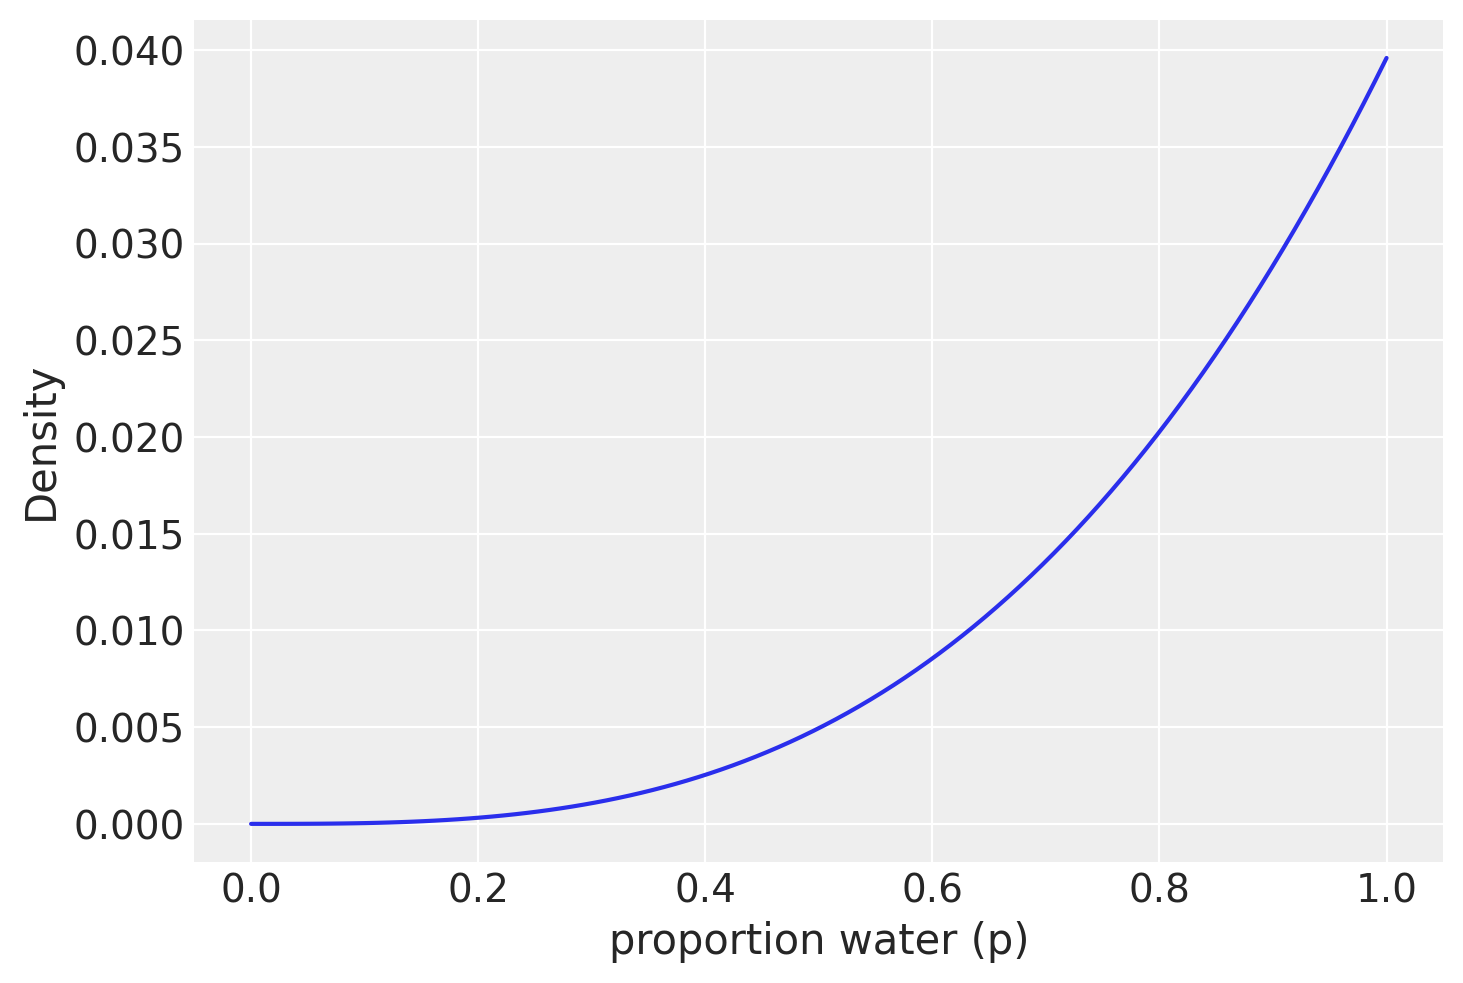

<IPython.core.display.Javascript object>

In [98]:
# repo is missing grid_points parameter at this line
p_grid, posterior = posterior_grid_approx(grid_points=100, success=3, tosses=3)

plt.plot(p_grid, posterior)
plt.xlabel("proportion water (p)")
plt.ylabel("Density")

# Code 3.12

You can conveniently compute the 50% compatibility interval from the samples with PI (part of rethinking):

## R

In [103]:
%%R

PI( samples , prob=0.5 )

      25%       75% 
0.7057057 0.9309309 


<IPython.core.display.Javascript object>

## Python

In [104]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.70707071, 0.93939394])

<IPython.core.display.Javascript object>

# Code 3.13

Plot the HDPI instead.

## R

In [106]:
%%R

HPDI( samples , prob=0.5 )

     |0.5      0.5| 
0.8398398 1.0000000 


<IPython.core.display.Javascript object>

## Python

This is the first time I'm seeing the [arviz](https://arviz-devs.github.io/arviz/) package being used.

In [108]:
az.hdi(samples, hdi_prob=0.5)

array([0.84848485, 1.        ])

<IPython.core.display.Javascript object>

# Code 3.14

Getting maximum a posteriori (MAP) estimate.

## R

In [109]:
%%R

p_grid[ which.max(posterior) ]

[1] 1


<IPython.core.display.Javascript object>

## Python

In [110]:
p_grid[posterior == max(posterior)]

array([1.])

<IPython.core.display.Javascript object>

In [114]:
# Inspect the table
pd.DataFrame({"p_grid": p_grid, "posterior": posterior})

,p_grid,posterior
0,0.000000,0.000000e+00
1,0.010101,4.081216e-08
2,0.020202,3.264973e-07
3,0.030303,1.101928e-06
4,0.040404,2.611978e-06
...,...,...
95,0.959596,3.499133e-02
96,0.969697,3.610799e-02
97,0.979798,3.724816e-02
98,0.989899,3.841208e-02


<IPython.core.display.Javascript object>

# Code 3.15

"If you instead have samples from the posterior, you can still approximate the same point."  (not sure I get this).

## R

In [116]:
%%R

chainmode( samples , adj=0.01 )

[1] 0.9368482


<IPython.core.display.Javascript object>

## Python




In [117]:
stats.mode(samples)[0]

array([1.])

<IPython.core.display.Javascript object>

In [118]:
samples

array([0.87878788, 0.95959596, 0.92929293, ..., 0.97979798, 0.94949495,
       0.85858586])

<IPython.core.display.Javascript object>

# Code 3.16

Other point estimates: posterior mean or median

## R

In [122]:
%%R

print(mean( samples ))


print(median( samples ))

[1] 0.7983591
[1] 0.8398398


<IPython.core.display.Javascript object>

## Python




In [123]:
np.mean(samples), np.median(samples)

(0.8043969696969698, 0.8484848484848485)

<IPython.core.display.Javascript object>

# Code 3.17 Loss function (perhaps come back to this)

**Loss function** A loss function is a rule that tells you the cost associated with using any particular point estimate. *The key insight is that different loss functions imply different point estimates.* In this scenario,  loss is proportional to the absolute value of d − p, where d is your decision and p is the correct answer.


Calculating expected loss for any given decision means using the posterior to average over our uncertainty in the true value. Of course we don’t know the true value, in most cases. But if we are going to use our model’s information about the parameter, that means using the entire posterior distribution. So suppose we decide $p$=0.5 will be our decision. Then the expected loss will be:

## R

In [124]:
%%R

sum( posterior*abs( 0.5 - p_grid ) )

[1] 0.3128752


<IPython.core.display.Javascript object>

## Python




In [125]:
sum(posterior * abs(0.5 - p_grid))

0.31626874808692995

<IPython.core.display.Javascript object>

# Code 3.18 and 3.19

A trick for repeating this calculation for every possible decision, using the function `sapply`.


## R

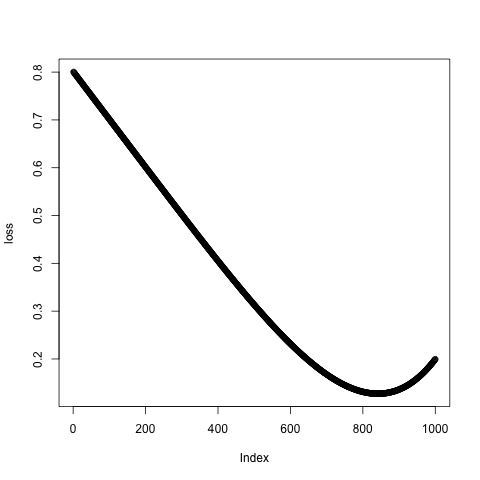

<IPython.core.display.Javascript object>

In [128]:
%%R

loss <- sapply( p_grid , function(d) sum( posterior*abs( d - p_grid ) ) )
plot(loss)

In [137]:
%%R
p_grid[ which.min(loss) ]

[1] 0.8408408


<IPython.core.display.Javascript object>

## Python




In [138]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]

<IPython.core.display.Javascript object>

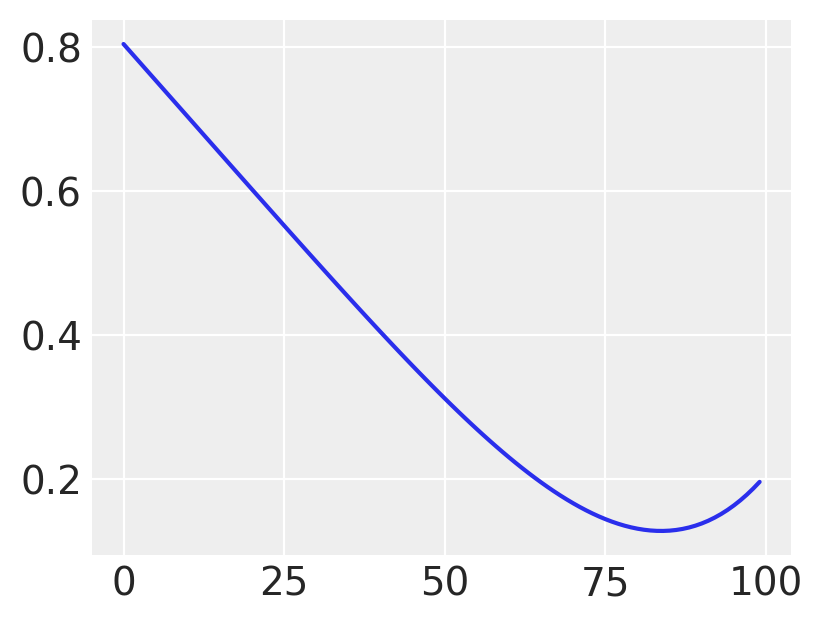

<IPython.core.display.Javascript object>

In [134]:
_, ax = plt.subplots(figsize=(4, 3))
ax.plot(loss)

In [139]:
p_grid[loss == min(loss)]

array([0.84848485])

<IPython.core.display.Javascript object>

# Code 3.20

Sampling to simulate prediction. Create simulated data AKA "dummy data".

With the globe tossing model, the dummy data arises from a binomial likelihood. Suppose N=2, two tosses of the globe. Then there are only three possible observations: 0 water, 1 water, 2 water.

Compute the probability for each possible observation. Assume p=0.7.

## R

In [140]:
%%R

dbinom( 0:2 , size=2 , prob=0.7 )

[1] 0.09 0.42 0.49


<IPython.core.display.Javascript object>

## Python




In [141]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

<IPython.core.display.Javascript object>

# Code 3.21

Now sample (once) from this distribution.

## R

In [142]:
%%R

rbinom( 1 , size=2 , prob=0.7 )

[1] 2


<IPython.core.display.Javascript object>

## Python




In [143]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([1])

<IPython.core.display.Javascript object>

# Code 3.22

Sample ten times from this distribution.

## R

In [144]:
%%R

rbinom( 10 , size=2 , prob=0.7 )

 [1] 2 2 2 1 2 2 2 1 1 2


<IPython.core.display.Javascript object>

## Python




In [145]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([1, 1, 1, 2, 1, 2, 2, 2, 2, 1])

<IPython.core.display.Javascript object>

# Code 3.23

Generate 100,000 dummy observations, just to verify that each value (0, 1, or 2) appears in proportion to its likelihood.

## R

In [146]:
%%R

dummy_w <- rbinom( 1e5 , size=2 , prob=0.7 )
table(dummy_w)/1e5

dummy_w
      0       1       2 
0.08941 0.42222 0.48837 


<IPython.core.display.Javascript object>

## Python




In [147]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.09023, 0.41933, 0.49044]

<IPython.core.display.Javascript object>

# Code 3.24

## R

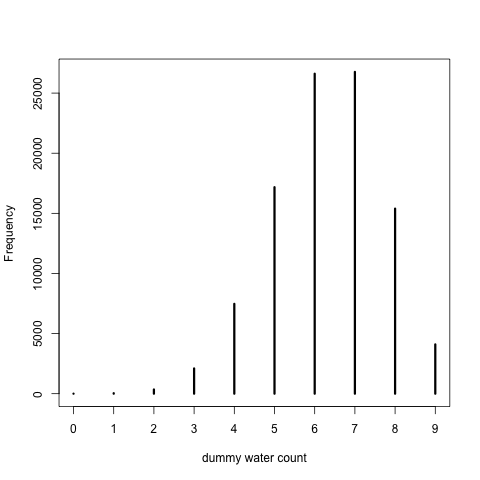

<IPython.core.display.Javascript object>

In [149]:
%%R

dummy_w <- rbinom( 1e5 , size=9 , prob=0.7 )
simplehist( dummy_w , xlab="dummy water count")

## Python

In [this repo](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_03.ipynb), they combine the code for 3.24, 3.25, and 3.26 but I thought it was important enough to look at things separately.

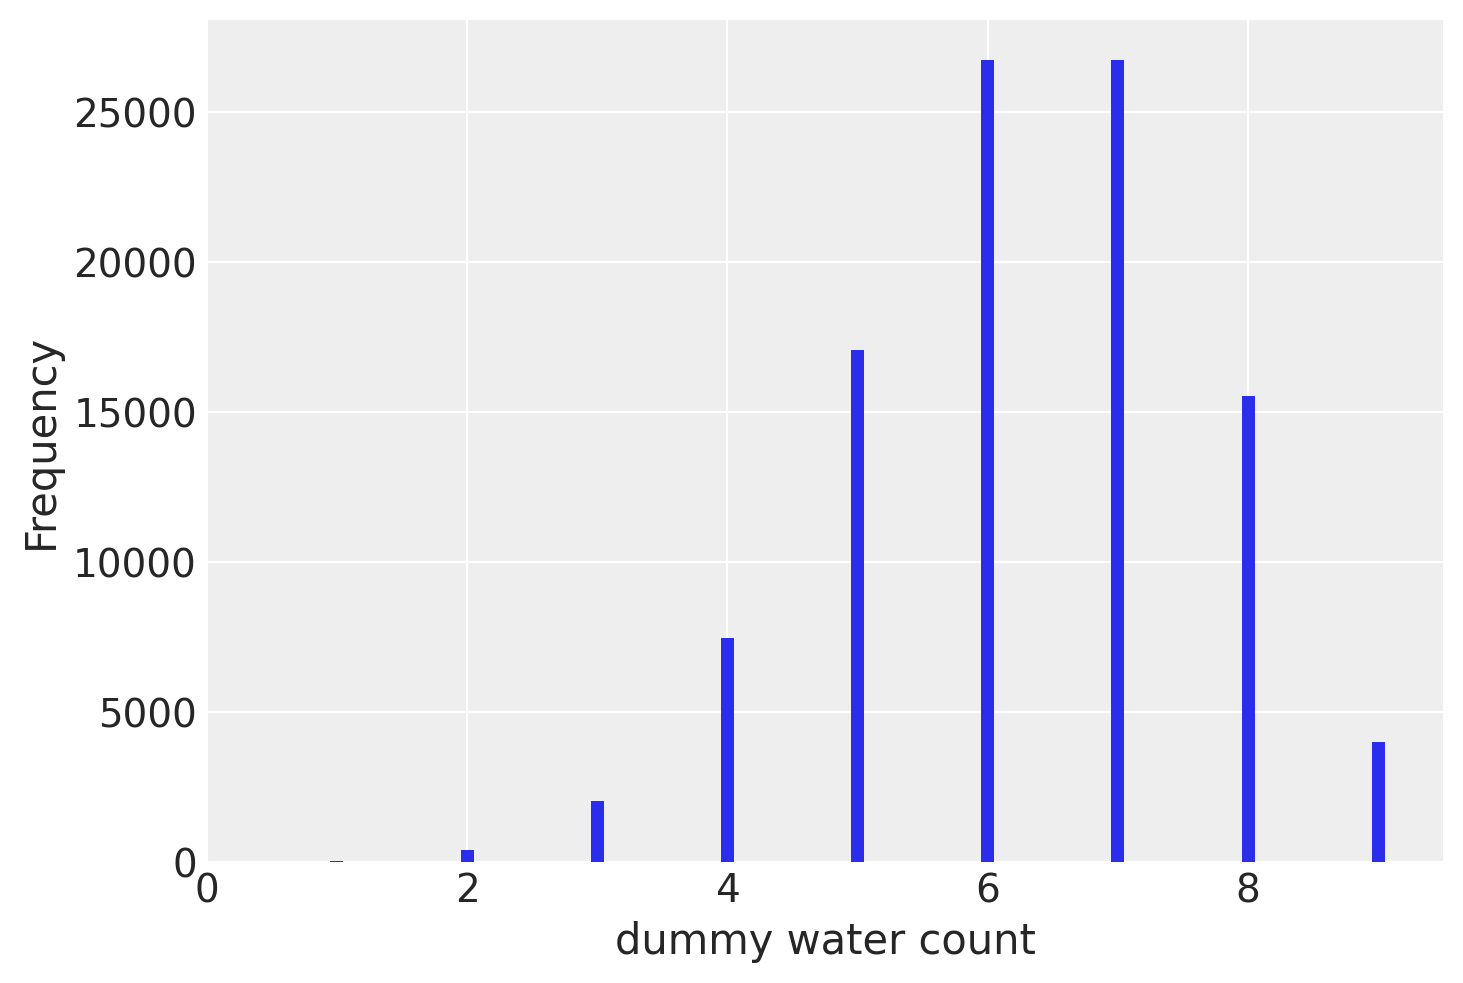

<IPython.core.display.Javascript object>

In [150]:
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
# dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
# dummy_w = stats.binom.rvs(n=9, p=samples)
bar_width = 0.1
plt.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
plt.xlim(0, 9.5)
plt.xlabel("dummy water count")
plt.ylabel("Frequency")

# Code 3.25, 3.26 - Model checking and the posterior predictive distribution

**Model checking and recognizing uncertainty in both the parameter *p* and predicted observed events.**


Combine sampling of simulated observations with smpling parameters from the posterior distribution. **We expect to do better when we use the entire posterior distribution, not just some point estimate derived from it.** Why? Because there is a lot of information about uncertainty in the entire posterior distribution. We lose this information when we pluck out a single parameter value and then perform calculations with it. This loss of information leads to overconfidence. (Above, we only used p=0.7).

Let’s do some basic model checks, using simulated observations for the globe tossing model. The observations in our example case are counts of water, over tosses of the globe. The implied predictions of the model are uncertain in two ways, and it’s important to be aware of both.

First, there is **observation uncertainty**. For any unique value of the parameter p, there is a unique implied pattern of observations that the model expects. These patterns of observations are the same gardens of forking data that you explored in the previous chapter. These patterns are also what you sampled in the previous section. There is uncertainty in the predicted observations, because even if you know p with certainty, you won’t know the next globe toss with certainty (unless p=0 or p=1).


Second, there is **uncertainty about p itself**. The posterior distribution over p embodies this uncertainty. And since there is uncertainty about p, there is uncertainty about everything that depends upon p. The uncertainty in p will interact with the sampling variation, when we try to assess what the model tells us about outcomes.

We’d like to propagate the parameter uncertainty—carry it forward—as we evaluate the implied predictions. All that is required is averaging over the posterior density for p, while computing the predictions. For each possible value of the parameter p, there is an implied distribution of outcomes. So if you were to compute the sampling distribution of outcomes at each value of p, then you could average all of these prediction distributions together, using the posterior probabilities of each value of p, to get a **POSTERIOR PREDICTIVE DISTRIBUTION**.

See [Figure 3.6](https://learning.oreilly.com/library/view/statistical-rethinking-2nd/9780429639142/xhtml/11_Chapter03.xhtml#fig3_6). That figure illustrates this averaging. At the top, the posterior distribution is shown, with 10 unique parameter values highlighted by the vertical lines. The implied distribution of observations specific to each of these parameter values is shown in the middle row of plots. Observations are never certain for any value of p, but they do shift around in response to it. Finally, at the bottom, the sampling distributions for all values of p are combined, using the posterior probabilities to compute the weighted average frequency of each possible observation, zero to nine water samples.

How to actually code this up?

## R

This is for a single value of p (0.6) is for a single value of p (0.6).

In [ ]:
%%R

# Code 3.25
w <- rbinom( 1e4 , size=9 , prob=0.6 )

To propagate parameter uncertainty into these predictions is replace the value 0.6 with samples from the posterior

In [152]:
%%R
head(samples, 20)     # Take a look at some values

 [1] 0.8288288 0.8778779 0.8358358 0.8448448 0.9959960 0.7767768 0.4504505
 [8] 0.9919920 0.9699700 0.9419419 0.8838839 0.7607608 0.6746747 0.9969970
[15] 0.9499499 0.6766767 0.5925926 0.9209209 0.6866867 0.8198198


<IPython.core.display.Javascript object>

In [160]:
%%R
# Code 3.26
w <- rbinom( 1e4 , size=9 , prob=samples )
head(w, 20)

 [1] 7 9 8 8 9 8 5 9 9 9 7 8 5 9 9 6 5 9 3 7


<IPython.core.display.Javascript object>

## Python


In [221]:
# Analog to code 3.25
# Single parameter value
p_singlep = 0.6
dummy_w1p = stats.binom.rvs(n=9, p=p_singlep, size=int(1e4))

# Variable name in plot below
# https://stackoverflow.com/questions/10439694/how-to-put-a-variable-in-x-y-label-using-matplotlib-module-pyplot

<IPython.core.display.Javascript object>

In [196]:
# Re-run this to get samples again to have multiple parameter values
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
np.random.seed(100)

# Multiple parameter values
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
samples[0:20]

array([0.65656566, 0.55555556, 0.61616162, 0.77777778, 0.26262626,
       0.46464646, 0.70707071, 0.76767677, 0.47474747, 0.67676768,
       0.80808081, 0.52525253, 0.50505051, 0.45454545, 0.52525253,
       0.88888889, 0.76767677, 0.50505051, 0.76767677, 0.55555556])

<IPython.core.display.Javascript object>

In [182]:
# Analog to code 3.26
dummy_w = stats.binom.rvs(n=9, p=samples, size=int(1e4))

<IPython.core.display.Javascript object>

In [183]:
dummy_w[0:20]

array([4, 1, 3, 8, 3, 5, 8, 7, 2, 7, 7, 6, 4, 4, 6, 8, 7, 3, 7, 6])

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Posterior predictive distribution with\nmultiple parameters')

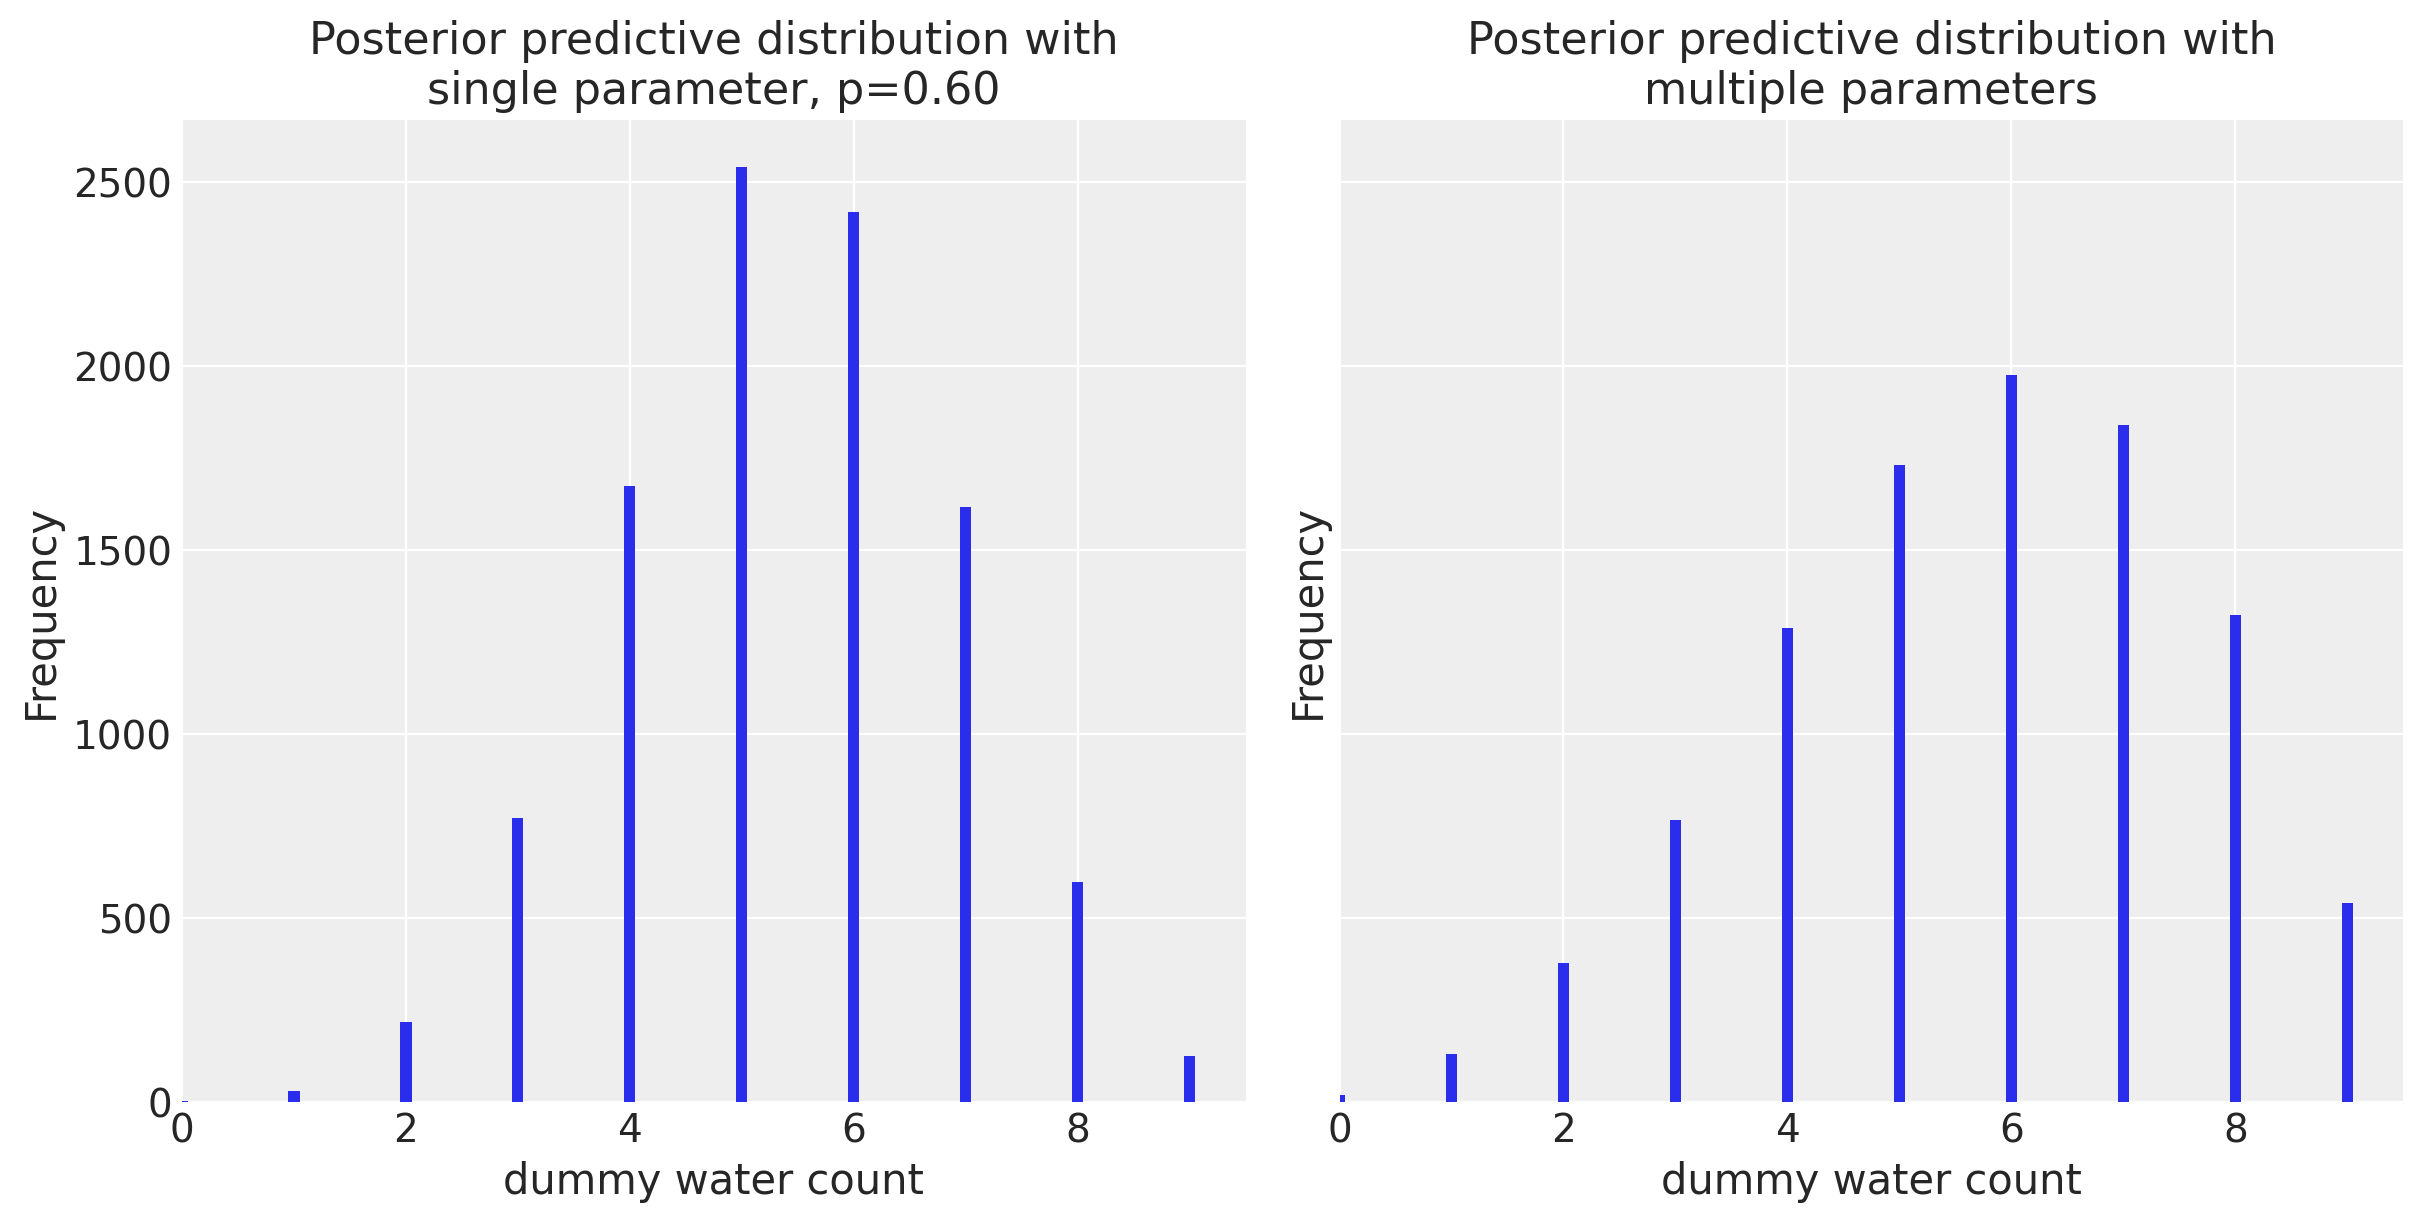

<IPython.core.display.Javascript object>

In [226]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
bar_width = 0.1
ax1.hist(dummy_w1p, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
ax1.set_xlim(0, 9.5)
ax1.set_xlabel("dummy water count")
ax1.set_ylabel("Frequency")
ax1.set_title(
    "Posterior predictive distribution with\nsingle parameter, p={:.2f}".format(
        p_singlep
    )
)

ax2.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
ax2.set_xlim(0, 9.5)
ax2.set_xlabel("dummy water count")
ax2.set_ylabel("Frequency")
ax2.set_title(
    "Posterior predictive distribution with\nmultiple parameters")


**Note how the second plot shows greater uncertainty in the posterior predictive distribution.**

In [ ]:
# ERROR IN CODE TO BE EDITED IN DEMO (make set_xlabel, etc.)
# f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharey=True)
# bar_width = 0.1
# ax1.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
# ax1.xlim(0, 9.5)
# ax1.xlabel("dummy water count")
# ax1.ylabel("Frequency")
# ax1.title("Posterior predictive distribution with single parameter (p=f"{p_singlep})")

In [223]:
# ERROR IN CODE TO BE EDITED IN DEMO (change second ax1 to ax2)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# bar_width = 0.1
# ax1.hist(dummy_w1p, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
# ax1.set_xlim(0, 9.5)
# ax1.set_xlabel("dummy water count")
# ax1.set_ylabel("Frequency")
# ax1.set_title(
#     "Posterior predictive distribution with\nsingle parameter, p={:.2f}".format(
#         p_singlep
#     )
# )

# ax1.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
# ax1.set_xlim(0, 9.5)
# ax1.set_xlabel("dummy water count")
# ax1.set_ylabel("Frequency")
# ax1.set_title(
#     "Posterior predictive distribution with\nmultiple parameters)
# )


<IPython.core.display.Javascript object>

# Follow-up for me

Make it clearer what the distinction is between the posterior probability and the posterior predictive distribution. See my blog post.

# Appendix: Environment and system parameters

In [66]:
%watermark -n -u -v -iv -w

Last updated: Fri Feb 12 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

seaborn   : 0.11.1
json      : 2.0.9
numpy     : 1.20.1
pymc3     : 3.11.0
pandas    : 1.2.1
matplotlib: 3.3.4
scipy     : 1.6.0
arviz     : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>

In [67]:
# Custom scripts to show packages and versions in this notebook
def imports():
    import types

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__


imported_packages = list(imports())

from active_pkg import show_pkg_vers_in_nb

show_pkg_vers_in_nb(imported_packages)

# Name                    Version                   Build  Channel
arviz                     0.11.1                   pypi_0    pypi
matplotlib                3.3.4                    pypi_0    pypi
numpy                     1.20.1                   pypi_0    pypi
pandas                    1.2.1                    pypi_0    pypi
pymc3                     3.11.0                   pypi_0    pypi
scipy                     1.6.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi


<IPython.core.display.Javascript object>